In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
df = pd.read_csv("Sample - Superstore.csv")

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit;
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2.0,0.00,41.9136;
1,"2,CA-2016-152156,11/8/2016,11/11/2016,Second C...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.00,6.8714;
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,0.45,-383.031;
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.20,2.5164;


In [4]:
# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales data by date to prepare for forecasting
df_sales = df.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()

In [5]:
df.tail()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit;
9989,9990,CA-2014-110422,2014-01-21,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180.0,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3.0,0.2,4.1028;
9990,9991,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627.0,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2.0,0.0,15.6332;
9991,9992,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627.0,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.576,2.0,0.2,19.3932;
9992,"9993,CA-2017-121258,2/26/2017,3/3/2017,Standar...",NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9993,"9994,CA-2017-119914,5/4/2017,5/9/2017,Second C...",NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   object        
 1   Order ID       7484 non-null   object        
 2   Order Date     7484 non-null   datetime64[ns]
 3   Ship Date      7484 non-null   object        
 4   Ship Mode      7484 non-null   object        
 5   Customer ID    7484 non-null   object        
 6   Customer Name  7484 non-null   object        
 7   Segment        7484 non-null   object        
 8   Country        7484 non-null   object        
 9   City           7484 non-null   object        
 10  State          7484 non-null   object        
 11  Postal Code    7484 non-null   float64       
 12  Region         7484 non-null   object        
 13  Product ID     7484 non-null   object        
 14  Category       7484 non-null   object        
 15  Sub-Category   7484 n

In [7]:
df.isna().sum()

Row ID              0
Order ID         2510
Order Date       2510
Ship Date        2510
Ship Mode        2510
Customer ID      2510
Customer Name    2510
Segment          2510
Country          2510
City             2510
State            2510
Postal Code      2510
Region           2510
Product ID       2510
Category         2510
Sub-Category     2510
Product Name     2510
Sales            2510
Quantity         2510
Discount         2510
Profit;          2510
dtype: int64

In [8]:
df.describe()

,Order Date,Postal Code,Sales,Quantity,Discount
count,7484,7484.000000,7484.000000,7484.000000,7484.000000
mean,2016-04-28 16:22:03.784072704,55587.591529,246.987420,3.776991,0.154969
min,2014-01-04 00:00:00,1040.000000,0.444000,1.000000,0.000000
25%,2015-05-14 00:00:00,23602.000000,16.272000,2.000000,0.000000
50%,2016-06-23 00:00:00,60035.000000,54.580000,3.000000,0.200000
75%,2017-05-14 00:00:00,90008.000000,223.920000,5.000000,0.200000
max,2017-12-30 00:00:00,99301.000000,22638.480000,14.000000,0.800000
std,NaN,31990.451627,674.440108,2.212994,0.205513


In [9]:
# what about duplication 
df.duplicated().sum()

0

In [10]:
# Group the data by Product Name and sum up the sales by product
print(df.dtypes)

if not pd.api.types.is_numeric_dtype(df["Sales"]):
    df["Sales"] = pd.to_numeric(df["Sales"], errors="coerce")  

product_group = df.groupby("Product Name")["Sales"].sum()

print(product_group.head())

Row ID                   object
Order ID                 object
Order Date       datetime64[ns]
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code             float64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                float64
Discount                float64
Profit;                  object
dtype: object
Product Name
#10 Self-Seal White Envelopes                   108.682
#6 3/4 Gummed Flap White Envelopes               71.280
12 Colored Short Pencils                         18.200
12-1/2 Diameter Round Wall Clock                551.448
14-7/8 x 11 Blue Bar Computer Printout Paper    422.752
Name: Sales, dtype: f

In [11]:
product_group.head()


Product Name
#10 Self-Seal White Envelopes                   108.682
#6 3/4 Gummed Flap White Envelopes               71.280
12 Colored Short Pencils                         18.200
12-1/2 Diameter Round Wall Clock                551.448
14-7/8 x 11 Blue Bar Computer Printout Paper    422.752
Name: Sales, dtype: float64

In [13]:
# Sort the data by sales in descending order
top_selling_products = product_group.sort_values(ascending=False)
top_5_selling_products = pd.DataFrame(top_selling_products[:5])
top_5_selling_products

,Sales
Product Name,
Canon imageCLASS 2200 Advanced Copier,61599.824
Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind,27453.384
Cisco TelePresence System EX90 Videoconferencing Unit,22638.480
HON 5400 Series Task Chairs for Big and Tall,21870.576
GBC DocuBind TL300 Electric Binding System,19823.479


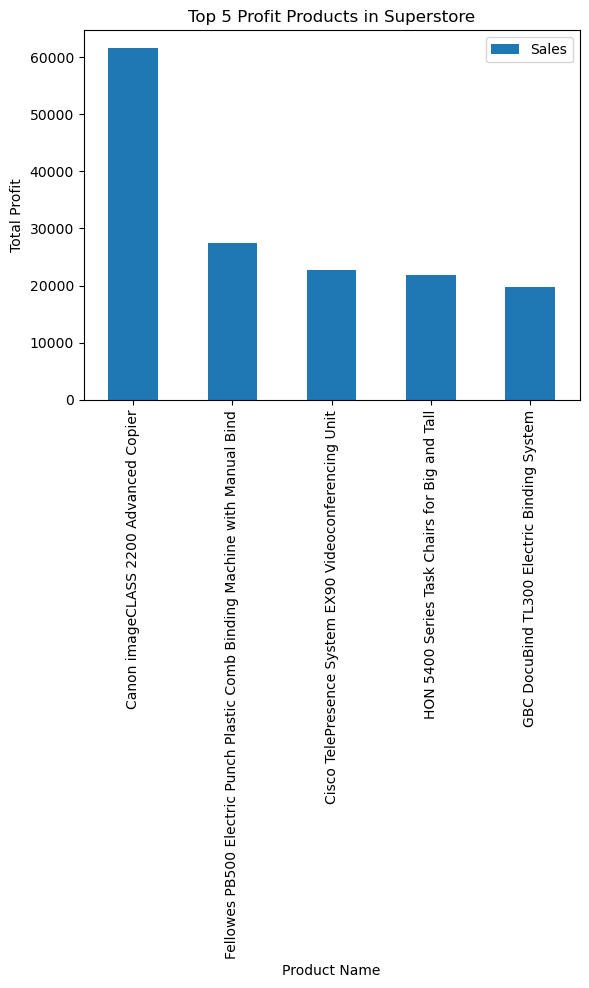

In [14]:
top_5_selling_products.plot(kind="bar")

# Add a title to the plot
plt.title("Top 5 Profit Products in Superstore")

# Add labels to the x and y axes
plt.xlabel("Product Name")
plt.ylabel("Total Profit")

# Show the plot
plt.show()

In [17]:
# Check basic statistics of the dataset
print("\nBasic Statistics of Sales Data:")
print(df_sales.describe())


Basic Statistics of Sales Data:
                          Order Date         Sales
count                           1191   1191.000000
mean   2016-01-31 03:48:30.831234048   1552.018348
min              2014-01-04 00:00:00      1.080000
25%              2015-01-30 12:00:00    269.861000
50%              2016-02-15 00:00:00    843.148000
75%              2017-01-26 12:00:00   2013.854000
max              2017-12-30 00:00:00  26755.266000
std                              NaN   2085.658575


In [18]:
# Check for missing values
print("\nMissing Values in Dataset:")
print(df_sales.isnull().sum())


Missing Values in Dataset:
Order Date    0
Sales         0
dtype: int64


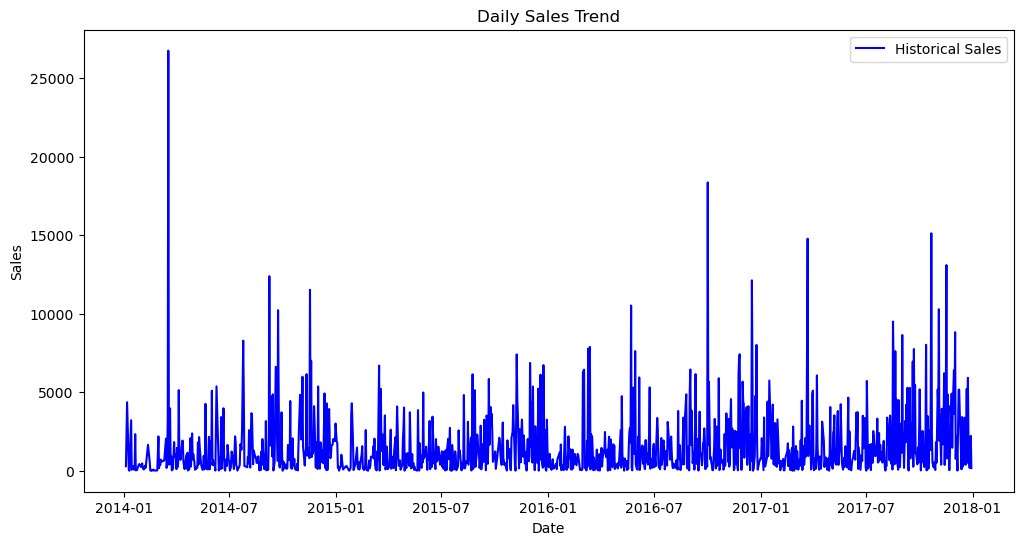

In [19]:
# Plot historical sales data
plt.figure(figsize=(12, 6))
plt.plot(df_sales['Order Date'], df_sales['Sales'], label='Historical Sales', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Trend')
plt.legend()
plt.show()

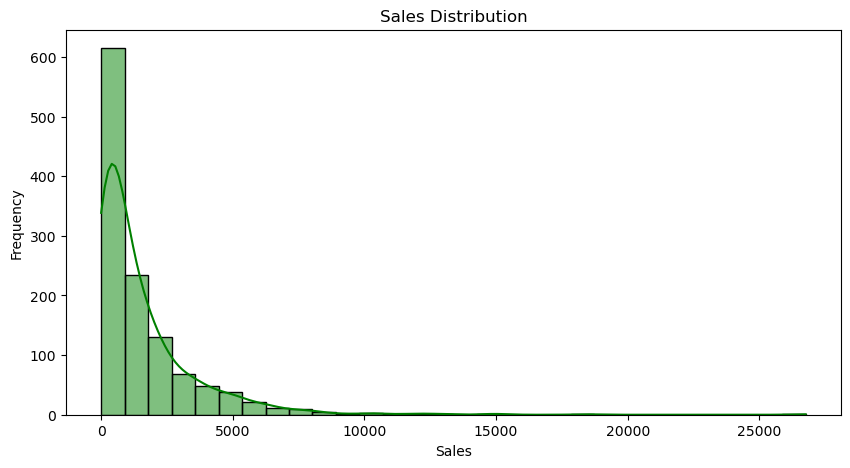

In [20]:
# Sales distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(df_sales['Sales'], bins=30, kde=True, color='green')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

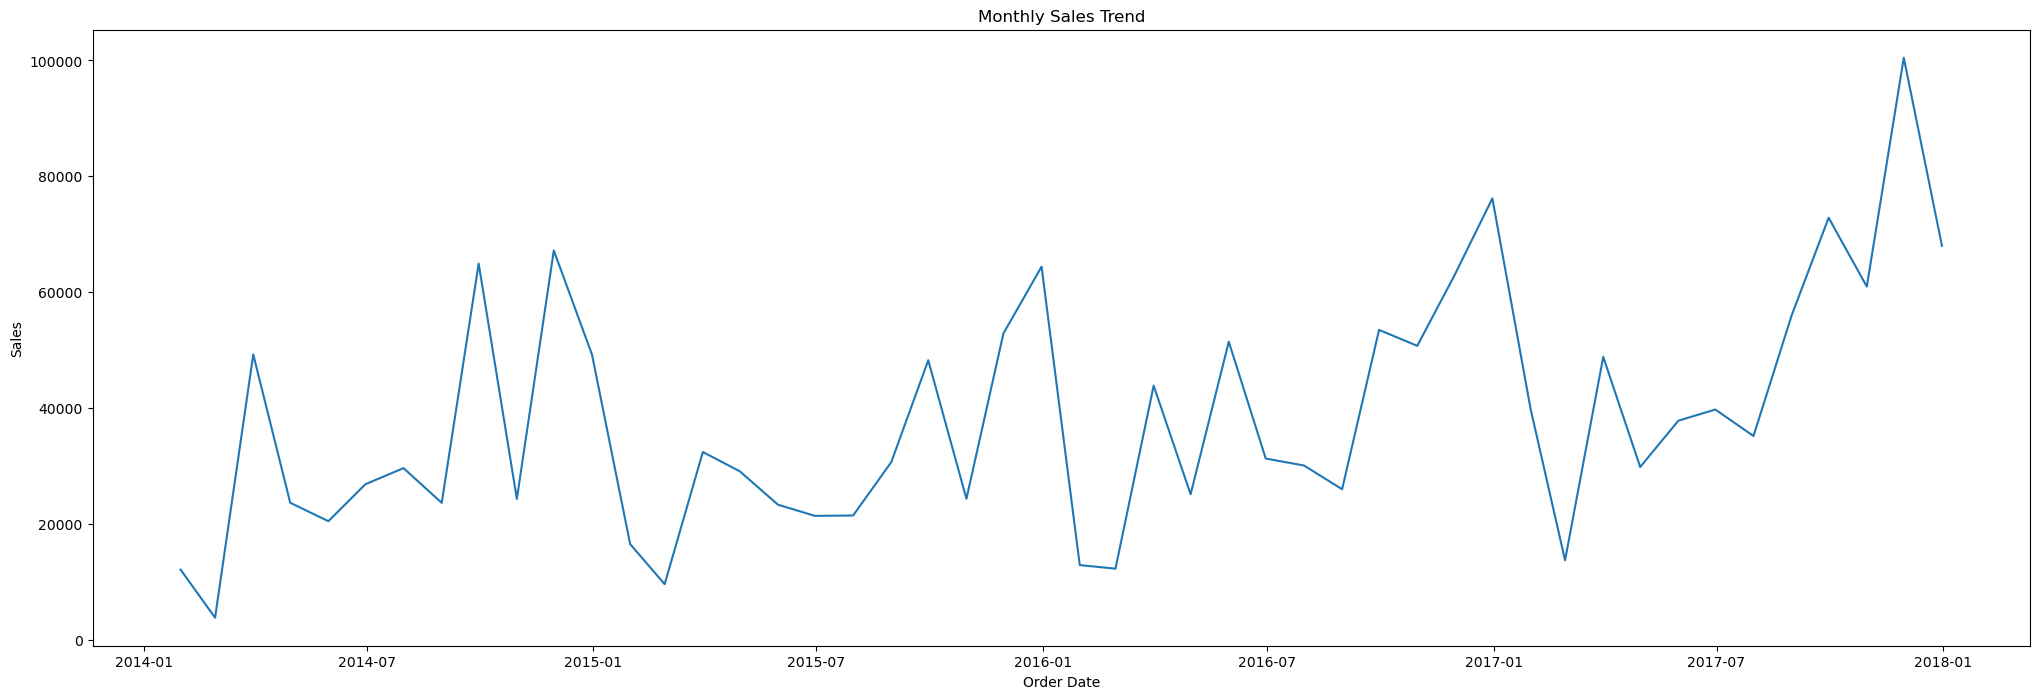

In [21]:
monthly_sales = df.groupby(['Order Date'], as_index=False).sum()

# Set the Order Date column as the index of the dataframe
monthly_sales = monthly_sales.set_index('Order Date')

# Resample the data into monthly intervals
monthly_sales = monthly_sales.resample('M').sum() # M for month

# Plot
plt.figure(figsize=(25,8))
plt.plot(monthly_sales['Sales'])
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.title("Monthly Sales Trend")
plt.show()

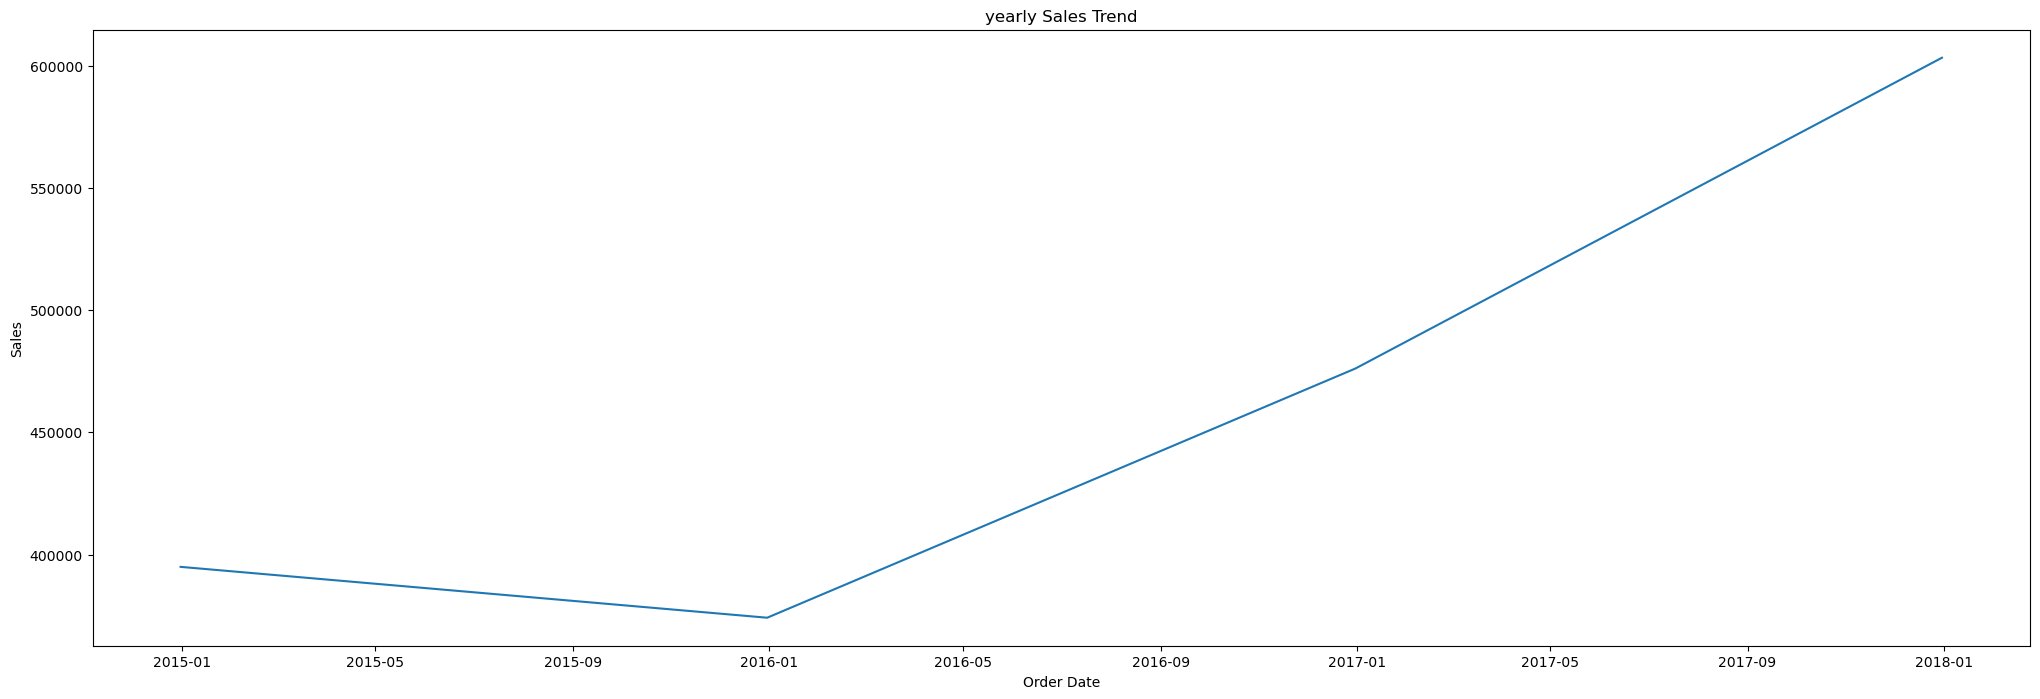

In [22]:
yearly_sales = monthly_sales.resample('Y').sum() 


plt.figure(figsize=(25,8))
plt.plot(yearly_sales['Sales'])
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.title("yearly Sales Trend")
plt.show()